## RECONHECIMENTO AUTOMÁTICO DE FALA 

In [1]:
from python_speech_features import mfcc
from playsound import playsound
from hmmlearn import hmm
import scipy.io.wavfile as wav
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pickle

### Ouvir as 200 palavras(20 para cada algarismo) 

In [60]:
for i in range(0,10):
    for j in range(1,21):
        addrs = str(i)+'/'+str(j)+'.wav'
        playsound(addrs)

In [73]:
# Ouvir apenas um som
playsound('ruido.wav')

### Definir função janela

Text(0, 0.5, 'w[n]')

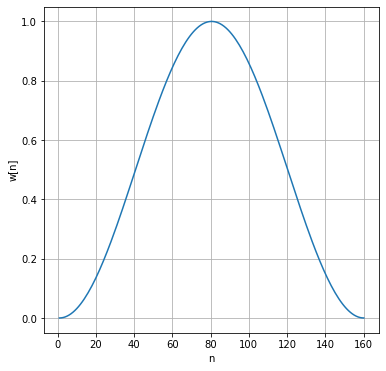

In [18]:
# Definir uma função janela-> Hann. Como fs=16000 Hz e janela de 10 ms, então 160 amostras.
win = np.hanning(160)
n = np.arange(1,161,1)
plt.figure(figsize=(6, 6))
plt.plot(n,win)
plt.grid()
plt.xlabel('n')
plt.ylabel('w[n]')

### Extrair MFCC do conjunto de treinamento

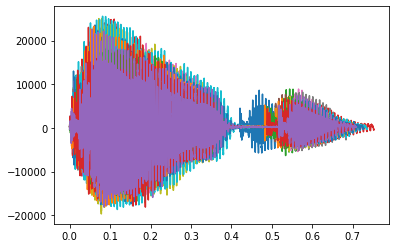

In [3]:
# sinal s, fs=16000 Hz, winlen= 0.01 s, winstep=0.005 s, numcep=13, winfunc= np.hanning
coeffs=[]
for i in range(1,16):
    (fs,s) = wav.read('8/'+str(i)+'.wav')
    ts = np.arange(0,len(s),1)/fs
    plt.plot(ts,s)
    coeffs.append(mfcc(s,fs,winlen=0.01,winstep=0.005,numcep=13,winfunc=np.hanning))

### Treinamento do modelo oculto de Markov

In [12]:
n_estados = 3
# Matriz de transição inicial com topologia left-to-right
mat_trA = np.array([[0.5, 0.5, 0],
                    [0, 0.5, 0.5],
                    [0, 0, 1]])
mod = hmm.GaussianHMM(n_components=n_estados, covariance_type='diag', 
                       transmat_prior=mat_trA, params='mct', n_iter=10)
for i in range(0,15):
    mod.fit(coeffs[i],len(coeffs[i]))
mod.transmat_

Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'
Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'
Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'


array([[0.        , 0.        , 0.        ],
       [0.        , 0.97630647, 0.02369353],
       [0.        , 0.02827116, 0.97172884]])

### Salvando cada modelo

In [202]:
with open("mod8.pkl","wb") as file: pickle.dump(mod,file)

In [183]:
file = open("mod8.pkl","rb")
mod = pickle.load(file)
file.close()
mod.transmat_

array([[9.91665129e-01, 8.33487101e-03, 0.00000000e+00],
       [2.17482327e-08, 9.86563395e-01, 1.34365831e-02],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])

### Carregamento dos modelos

In [15]:
mod=[]
for i in range(0,10):
    adrs_mod = 'mod'+str(i)+'.pkl'
    file = open(adrs_mod,"rb")
    mod.append(pickle.load(file))
    file.close()
mod[1].transmat_

array([[0.99038465, 0.00961535, 0.        ],
       [0.        , 0.96666631, 0.03333369],
       [0.        , 0.        , 1.        ]])

### Extrair MFCC do conjunto de teste

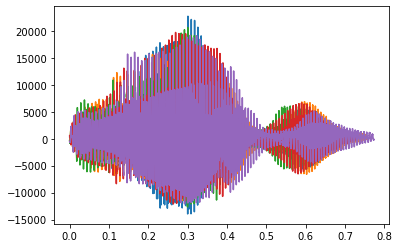

In [72]:
tstcoeffs=[]
for i in range(16,21):
    (fs,s) = wav.read('9/'+str(i)+'.wav')
    ts = np.arange(0,len(s),1)/fs
    plt.plot(ts,s)
    tstcoeffs.append(mfcc(s,fs,winlen=0.01,winstep=0.005,numcep=13,winfunc=np.hanning))

### Teste dos modelos

In [52]:
scor=[]
ind=[]
for i in range(0,5):
    for j in range(0,10):
        scor.append(mod[j].score(tstcoeffs[i],len(tstcoeffs[i])))
    ind.append(np.argmax(scor))
    scor=[]
print(ind)

[1, 1, 1, 1, 5]


### Corromper sinais de teste com ruído WGN

In [137]:
(fs,n) = wav.read('ruido.wav')
pot_rui = np.var(n)
print(pot_rui)
(fs,sig) = wav.read('9/16.wav')
pot_sig = np.var(sig)
print(pot_sig)
SNR = 10*np.log10(pot_sig/pot_rui)
print(SNR)

1879.9740895771185
13784299.601915011
38.652328402231056


In [7]:
snr = np.array([38,36,34,32,30])
for n in snr:
    for i in range(0,10):
        for j in range(16,21):
            adr = str(i)+'/'+str(j)+'.wav'
            (fs,sig) = wav.read(adr)
            pot_rui = np.var(sig)/(np.power(10,(n/10)))
            print(np.max(pot_rui))
            ruido = np.int16(np.random.normal(0,np.ceil(pot_rui),len(sig)))
            sigR = sig+ruido
            filename = str(i)+'-'+str(n)+str(j)+'.wav'
            wav.write(filename,fs,sigR)

3979.7257547160193
3226.9639690861177
4860.399909434264
3590.956922150452
5415.610162728058
4303.980290721685
9026.122319498289
10466.55806872319
6678.420862007498
5033.78266332472
3181.042042488066
1872.082385675113
2251.6600054940286
3778.4568878527853
2905.5397564324467
3451.724090831828
2966.617587100788
3844.768102999647
2822.117696259106
3283.0696323717266
2382.5952943752363
3064.1824659824983
1679.1218151730143
2588.1695833985223
3272.491204265072
2085.8078468410986
1901.621190150701
2376.495908015272
1878.925654493691
1748.02564865491
2641.3601495419107
2581.702780967974
1752.9089180692745
1708.3883951030543
1481.1899405483282
1648.2468535646703
1337.5863494512364
1677.250874338732
1331.0457863549025
1345.387258819768
4044.697885018703
4112.436833507078
4988.95979262093
4097.462664786043
4016.6191847798655
2184.664260191955
1903.4960124529864
1803.9553453650667
2427.6409324968668
2159.552079263863
6307.440256511582
5114.39322692188
7703.214729100973
5691.283180337361
8583.16367